#Fruit inspection: first task

Project work in Computer Vision by Alessio Comparini

In [ ]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from google.colab.patches import cv2_imshow***********

Let's start by reading the selected image

In [ ]:
SELECTED_IMAGE = 3 # 1, 2 or 3

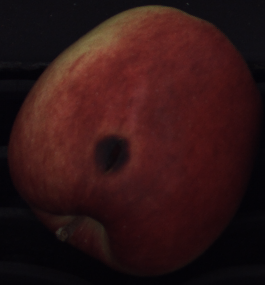

In [ ]:
nir_image = cv2.imread("C0_00000" + str(SELECTED_IMAGE) + ".png")
bw_image = cv2.imread("C0_00000" + str(SELECTED_IMAGE) + ".png",cv2.IMREAD_GRAYSCALE)
color_image = cv2.imread("C1_00000" + str(SELECTED_IMAGE) + ".png")

cv2_imshow(color_image)



```
# Questo è formattato come codice
```

##Extracting the apple mask

In order to extract the mask firstly a binarization on the nir image should be done. Since the images are very different between eachother, using an adaptive threshold is better then using a fixed threshold, and it finds easily the apple contour.

Those parameters have been chosen empirically.

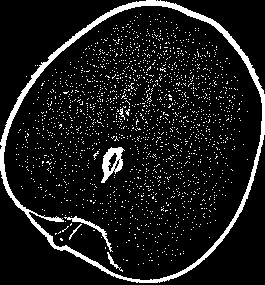

In [ ]:
tests = []
t_image = cv2.adaptiveThreshold(bw_image,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY_INV,17,4)
cv2_imshow(t_image)

The downside effect of using an adaptive threshold is that it generates several dots inside of the binarized apple. 
Since the next step is to detect the contours of the binarized image, we will perform an opening step so that the number of dots decreases and the function findContours performs better. 

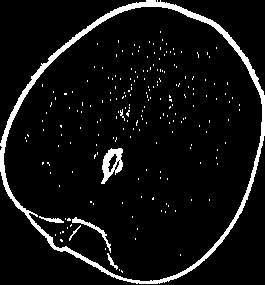

In [ ]:
t_open_image = cv2.morphologyEx(t_image, cv2.MORPH_OPEN, (3,3))
cv2_imshow(t_open_image)

Now let's find the apple contour.

In [ ]:
contours, hierarchy = cv2.findContours(t_open_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

The apple's contour is the biggest among all the found contours in the image.

Let's write a function that extracts the index of the biggest area contour.

In [ ]:
def argmax_contour(contours):
  maxArea = 0
  argmax_area = None
  for i,c in enumerate(contours):
    if cv2.contourArea(c) > maxArea:
      maxArea = cv2.contourArea(c)
      argmax_area = i
  return argmax_area

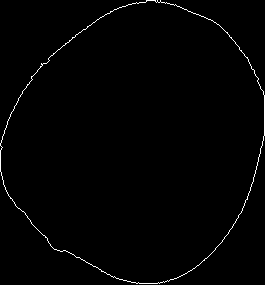

In [ ]:
mask=np.zeros(bw_image.shape,np.uint8)
cnt = contours[argmax_contour(contours)]
cv2.drawContours(mask, [cnt], 0, (255,255,255), 1)
contour_mask = mask.copy()
cv2_imshow(mask)

Filling the contouur with the fillPoly function of cv2 will return the mask.

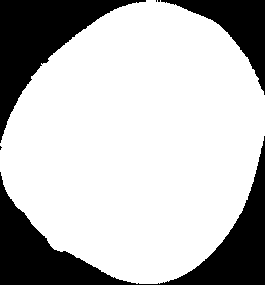

In [ ]:
cv2.fillPoly(mask, pts =[cnt], color=(255,255,255))
cv2_imshow(mask)

Getting the masked image.

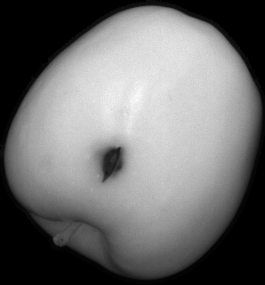

In [ ]:
masked_image = cv2.bitwise_and(nir_image, nir_image, mask=mask)
cv2_imshow(masked_image)

##Identifing the defects

The canny's edge detector could be used to identify the defects in the apples.

In order to get better results the image is blurred through a bilateral filter, so that the edges are preserved.

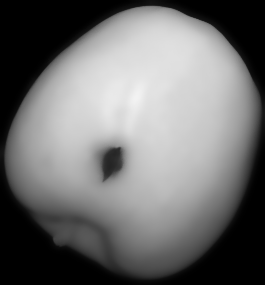

In [ ]:
blurred_image = cv2.bilateralFilter(masked_image, 11, 100, 75)
cv2_imshow(blurred_image)

Apply the edge detector. The parameters have been chosen empirically.

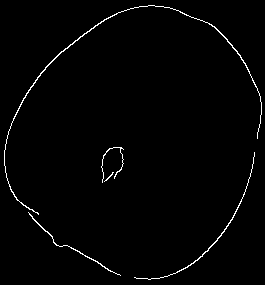

In [ ]:
canny = cv2.Canny(blurred_image, 0, 140)
cv2_imshow(canny)

The next step is avoiding to identify false defects, such as the points right next to the contour. To do that a dilatation operation is performed, such that the points next to the contour and the contour become the same thing.

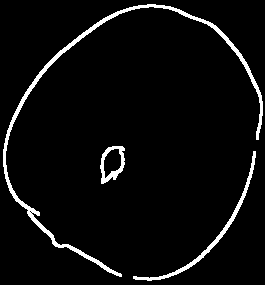

In [ ]:
kernel = np.ones((3, 3), np.uint8)
canny_dilated = cv2.dilate(canny, kernel, iterations=1)
cv2_imshow(canny_dilated)

Now running a contour detection will find not only the defects contours, but also the apple contour.

The contour detection will detect two contours belonging to the apple's contour (this is due to the dilatation applied before), and both of them are the biggest area contour found, so they can be easily excluded.

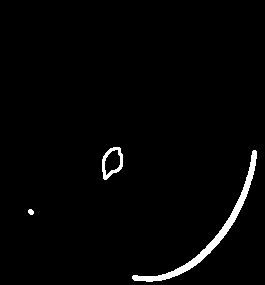

In [ ]:
contours_defects,hier_edge=cv2.findContours(canny_dilated,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
contours_defects = list(contours_defects)
del contours_defects[argmax_contour(contours_defects)]
del contours_defects[argmax_contour(contours_defects)]

no_biggest_contours = np.zeros(bw_image.shape, np.uint8)
cv2.drawContours(no_biggest_contours,contours_defects,-1,(255,255,255),2)
cv2_imshow(no_biggest_contours)

Unluckly some images, for example the third one, will show a strange behaviour due to the apple's contour detected by the canny's edge detector that is not continous.

This situation is solved using the apple's mask contour found at the beginning, dilatating it and perform a subtraction between the no_biggest_contour image and the new mask created.

The output of this operation will highlight only the defects inside of the apple.

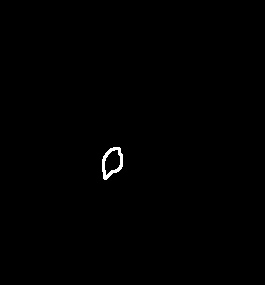

In [ ]:
kernel = np.ones((5, 5), np.uint8)
contour_mask_dilated = cv2.dilate(contour_mask, kernel, iterations=4)

defects_isolated = cv2.subtract(no_biggest_contours, contour_mask_dilated)
cv2_imshow(defects_isolated)

The final step consists just in showing a bounding box on each defect.

Using the command cv2.RETR_EXTERNAL on the function findContours will find only the external contours, which are the one we are interested in.

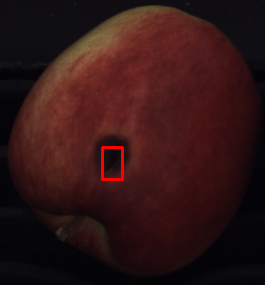

In [ ]:
contours_defects,hier_edge=cv2.findContours(defects_isolated,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
for c in contours_defects:
  rect = cv2.minAreaRect(c)
  box = cv2.boxPoints(rect)
  box = np.int0(box)
  cv2.drawContours(color_image,[box],0,(0,0,255),2)

cv2_imshow(color_image)